In [368]:
import sys
sys.path.append('../10_utils/')
import colorDict

age_color_dict = colorDict.age_color_dict()
tissue_color_dict = colorDict.tissue_color_dict()

In [371]:
tissue_color_dict

{'Bladder': '#393b79',
 'Brain_Myeloid': '#393b79',
 'Brain_Non-Myeloid': '#5254a3',
 'Fat': '#6b6ecf',
 'Heart_and_Aorta': '#9c9ede',
 'Kidney': '#637939',
 'Large_Intestine': '#8ca252',
 'Limb_Muscle': '#b5cf6b',
 'Liver': '#cedb9c',
 'Lung': '#8c6d31',
 'Mammary_Gland': '#bd9e39',
 'Marrow': '#e7ba52',
 'Pancreas': '#e7ba52',
 'Skin': '#e7cb94',
 'Spleen': '#843c39',
 'Thymus': '#ad494a',
 'Tongue': '#d6616b',
 'Trachea': '#e7969c',
 'BAT': '#7b4173',
 'GAT': '#a55194',
 'MAT': '#ce6dbd',
 'SCAT': '#de9ed6'}

In [1]:
import sys
sys.path.append('../../../../src/scVI/')
import scvi
from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer
from scvi.models import VAE, SCANVI
from scvi.dataset.anndataset import AnnDatasetFromAnnData

[2020-01-11 11:49:44,343] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/angela/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
scvi.__version__ 

'0.5.0'

In [81]:
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
torch.cuda.is_available()

True

In [5]:
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from typing import Tuple

In [6]:
from scvi.dataset import AnnDatasetFromAnnData

In [7]:
pwd

'/home/angela/maca/tabula-muris-senis/1_tabula_muris_senis/11_figure_1'

In [8]:
adata_droplet = sc.read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-droplet-official-raw-obj.h5ad')
display(adata_droplet)

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [234]:
adata_droplet#.obs['cell_ontology_class'] = adata_droplet.obs['cell_ontology_class_reannotated']

AnnData object with n_obs × n_vars = 245389 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [242]:
adata_droplet_small = adata_droplet[adata_droplet.obs['cell_ontology_class']=='hepatocyte'].copy()
adata_droplet_small = adata_droplet_small[adata_droplet_small.obs['age'].isin(['30m','3m'])].copy()
adata_droplet_small

AnnData object with n_obs × n_vars = 1019 × 20138 
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells'

In [251]:
adata#.obsm['X_umap'].shape#_droplet_small.obsm

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

In [10]:
# adata_droplet.obs = adata_droplet.obs.drop(
#     ['batch', 'cell', 'cell_ontology_class_reannotated', 'n_genes','tissue_free_annotation'],axis=1)
# adata_droplet

In [11]:
adata_facs = sc.read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-facs-official-raw-obj.h5ad')
display(adata_facs)

AnnData object with n_obs × n_vars = 110824 × 22966 
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [12]:
adata_facs.obs = adata_facs.obs.drop(['FACS.selection','cell'],axis=1)
adata_facs

AnnData object with n_obs × n_vars = 110824 × 22966 
    obs: 'age', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

In [13]:
adata = adata_droplet.concatenate(adata_facs)

In [14]:
sum(adata.obs.batch=='0'),sum(adata.obs.batch=='1')

(245389, 110824)

In [18]:
import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
from typing import Tuple


def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 10,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    """Train and return a scVI model and sample a latent space
    
    :param adata: sc.AnnData object non-normalized
    :param n_latent: dimension of the latent space
    :param n_epochs: number of training epochs
    :param lr: learning rate
    :param use_batches
    :param use_cuda
    :return: (scvi.Posterior, latent_space)
    """
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata,batch_label = 'batch')

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_hidden=128, n_latent=30, n_layers=5, dispersion='gene'
    )
    trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)
    trainer.train(n_epochs=n_epochs, lr=lr)
    ####
    
    torch.save(trainer.model.state_dict(), 'tms-scVI-trainer-model')

    # Extract latent space
    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent


In [19]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation'
    var: 'n_cells-0', 'n_cells-1'

In [20]:
n_epochs_all = None
n_epochs = 100 if n_epochs_all is None else n_epochs_all

scvi_posterior, scvi_latent = compute_scvi_latent(
    adata, n_epochs=n_epochs, n_latent=6,
    use_batches = True, use_cuda=True
)
adata.obsm["X_scvi"] = scvi_latent

[2020-01-11 11:50:34,967] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-11 11:50:34,978] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-11 11:50:38,110] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-11 11:50:41,200] INFO - scvi.dataset.dataset | Downsampled from 356213 to 356213 cells


training: 100%|██████████| 100/100 [1:57:05<00:00, 70.25s/it]


In [23]:
adata.write('tms-scVI-adata.h5ad')

... storing 'age' as categorical
... storing 'cell' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical
... storing 'tissue_free_annotation' as categorical


In [ ]:
trainer = UnsupervisedTrainer(vae, scviDataset, train_size=.99, use_cuda=use_cuda)
trainer.model.load_state_dict(torch.load('tms-scVI-trainer-model'))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv

sc.settings.verbosity = 3
sc.logging.print_versions()
np.random.seed(685)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.set_figure_params(dpi=50)

In [ ]:
# adata = read_h5ad('../../0_data_ingest/01_figure_1/tabula-muris-senis-scVI-official-annotations-umap.h5ad')
adata = read_h5ad('../../../tabula-muris-senis-scVI-official-annotations.h5ad')
adata

computing PCA with n_comps = 50
    finished (0:02:23.92)


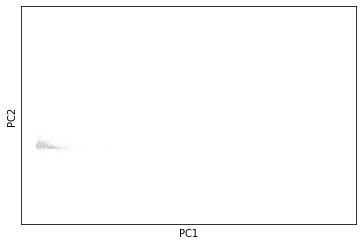

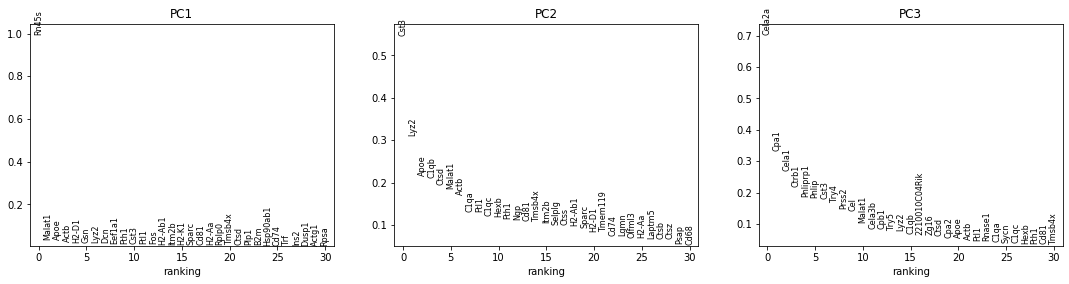

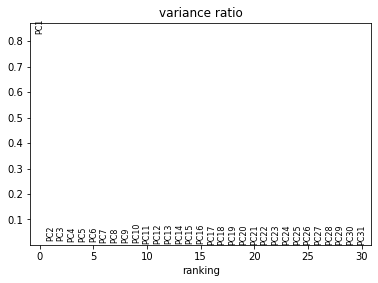

In [24]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_overview(adata)

In [633]:
sc.pp.neighbors(adata, use_rep="X_scvi", n_pcs=40)#, n_neighbors=15
sc.tl.umap(adata)

computing neighbors


/home/angela/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:01:23.50) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:07:43.36) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [634]:
sc.tl.louvain(adata, key_added="louvain_scvi")#, resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:05:19.09) --> found 60 clusters and added
    'louvain_scvi', the cluster labels (adata.obs, categorical)


In [27]:
adata.obs[adata.obs['cell_ontology_class']=='B cell']

,age,batch,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_counts,n_genes,sex,subtissue,tissue,tissue_free_annotation,louvain_scvi
AAACGGGGTAAGTTCC-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAACGGGGTAAGTTCC,B cell,NA,B cell,droplet,18-F-50,NaN,1966.0,female,nan,Mammary_Gland,Mammary_Gland,35
AAACGGGTCGAATGGG-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAACGGGTCGAATGGG,B cell,NA,B cell,droplet,18-F-50,NaN,1252.0,female,nan,Mammary_Gland,Mammary_Gland,43
AACTCAGCAGGTCCAC-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AACTCAGCAGGTCCAC,B cell,NA,B cell,droplet,18-F-50,NaN,1056.0,female,nan,Mammary_Gland,Mammary_Gland,10
AAGTCTGGTTCGTGAT-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_AAGTCTGGTTCGTGAT,B cell,NA,B cell,droplet,18-F-50,NaN,1018.0,female,nan,Mammary_Gland,Mammary_Gland,35
ACGATGTGTAAGGATT-1-4-0-0-0,18m,0,MACA_18m_F_BREAST_50_ACGATGTGTAAGGATT,B cell,NA,B cell,droplet,18-F-50,NaN,1331.0,female,nan,Mammary_Gland,Mammary_Gland,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9.MAA000531.3_8_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_8_M,231316.0,1489.0,male,Fat,MAT,nan,0
P9.MAA000559.3_8_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,CD79a B cell,facs,3_8_M,410087.0,1780.0,male,nan,Spleen,nan,0
P9.MAA000877.3_11_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_11_M,608430.0,2375.0,male,Fat,MAT,nan,8
P9.MAA000914.3_9_M.1.1-1-1-1,3m,1,nan,B cell,CL:0000236,nan,facs,3_9_M,338307.0,1330.0,male,Fat,MAT,nan,35


In [254]:
tissue_color_dict

{'Bladder': '#393b79',
 'Brain_Myeloid': '#393b79',
 'Brain_Non-Myeloid': '#5254a3',
 'Fat': '#6b6ecf',
 'Heart_and_Aorta': '#9c9ede',
 'Kidney': '#637939',
 'Large_Intestine': '#8ca252',
 'Limb_Muscle': '#b5cf6b',
 'Liver': '#cedb9c',
 'Lung': '#8c6d31',
 'Mammary_Gland': '#bd9e39',
 'Marrow': '#e7ba52',
 'Pancreas': '#e7ba52',
 'Skin': '#e7cb94',
 'Spleen': '#843c39',
 'Thymus': '#ad494a',
 'Tongue': '#d6616b',
 'Trachea': '#e7969c',
 'BAT': '#7b4173',
 'GAT': '#a55194',
 'MAT': '#ce6dbd',
 'SCAT': '#de9ed6'}

In [255]:
set(adata.obs['tissue'])

{'Aorta',
 'BAT',
 'Bladder',
 'Brain_Myeloid',
 'Brain_Non-Myeloid',
 'Diaphragm',
 'Fat',
 'GAT',
 'Heart',
 'Heart_and_Aorta',
 'Kidney',
 'Large_Intestine',
 'Limb_Muscle',
 'Liver',
 'Lung',
 'MAT',
 'Mammary_Gland',
 'Marrow',
 'Pancreas',
 'SCAT',
 'Skin',
 'Spleen',
 'Thymus',
 'Tongue',
 'Trachea'}

In [252]:
adata_nonans.uns['tissue_colors'] = list(maca_color_dict.values())

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'

... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'method' as categorical
... storing 'mouse.id' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical


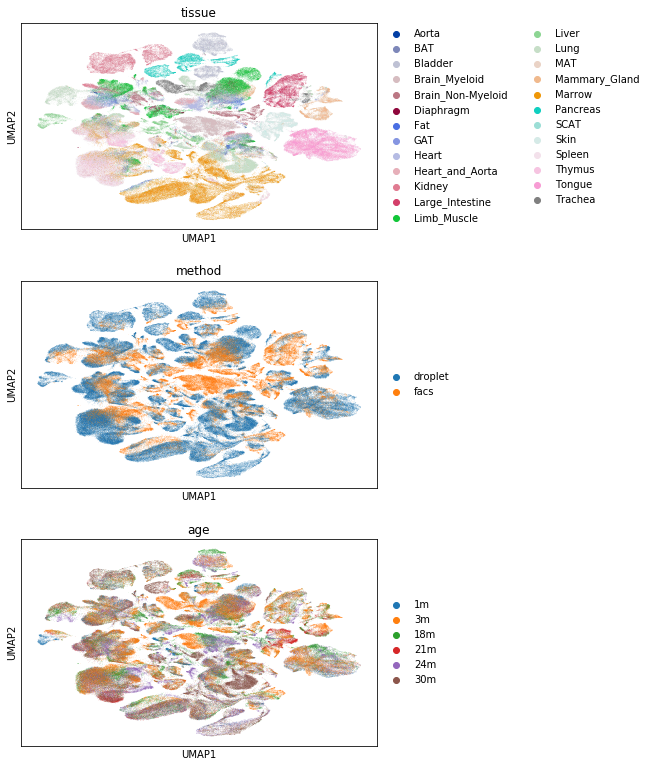

In [635]:
sc.pl.umap(adata,color=['tissue','method','age'],ncols=1)

In [636]:
adata

AnnData object with n_obs × n_vars = 356213 × 20116 
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_counts', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'louvain_scvi', 'tint', 'age_group'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'pca', 'neighbors', 'louvain', 'tissue_colors', 'rank_genes_groups_scvi', 'rank_genes_groups_wilcox', 'method_colors', 'age_colors'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'